In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os 
import datetime
from scipy import stats
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap

In [3]:
vis = pd.read_csv("../data/vis_12_2021_03_2022.csv", index_col=[0])
vis.index = pd.to_datetime(vis.index, format="%d/%m/%Y")
vis

,ABK,ABE,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YOL,ZAR,YEN
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01,10.0,13.0,10.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,...,NaN,10.0,10.0,16.0,6.0,20.0,5.3,10.0,8.0,10.0
2021-12-02,10.0,10.0,10.0,10.0,8.0,10.0,10.0,1.5,10.0,10.0,...,NaN,20.0,7.0,NaN,10.0,20.0,20.0,1.0,3.0,NaN
2021-12-03,10.0,13.0,3.0,13.0,10.0,10.0,10.0,1.0,10.0,1.0,...,NaN,20.0,3.0,15.0,7.0,20.0,1.5,1.6,1.0,10.0
2021-12-04,8.0,12.0,5.0,4.5,8.0,8.0,8.0,6.0,6.0,1.0,...,NaN,15.0,4.0,8.0,8.0,10.0,1.5,2.0,2.0,10.0
2021-12-05,7.0,8.0,4.0,3.0,5.0,8.0,8.0,8.0,7.0,1.0,...,NaN,2.5,10.0,7.0,3.0,NaN,3.5,5.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-27,10.0,12.0,4.0,12.0,10.0,8.0,10.0,1.2,10.0,2.0,...,1.5,18.0,0.8,8.0,10.0,10.0,2.0,2.0,0.8,10.0
2022-03-28,10.0,13.0,5.0,5.0,10.0,7.0,10.0,1.0,10.0,1.5,...,0.7,15.0,1.3,7.0,12.0,10.0,2.5,1.2,0.6,10.0
2022-03-29,10.0,15.0,4.0,4.0,10.0,7.0,10.0,1.8,10.0,3.0,...,2.5,15.0,1.5,10.0,10.0,10.0,2.0,1.2,0.8,10.0


In [4]:
stn_coord = pd.read_csv("../data/coords.csv")
stn = stn_coord["stn"]
stn_lat = stn_coord["lat"]
stn_lon = stn_coord["lon"]

In [14]:
# cap visibility maximum to 10km
# training set from Dec 2021 to Jan 2022, possible to add Feb?, validation for Mar??
vis.columns
for i in vis.columns:
    vis[i] = np.where(vis[i] > 10, 10, vis[i])
vis_train=vis.iloc[:90]
vis_test=vis.iloc[90:]
len_train=len(vis_train)
len_test=len(vis_test)

In [15]:
vis_train['KAN'].describe()

count    88.000000
mean      5.244318
std       3.443663
min       0.300000
25%       1.725000
50%       5.500000
75%       8.000000
max      10.000000
Name: KAN, dtype: float64

In [16]:
missing_train=np.isnan(vis_train).sum()
missing_test=np.isnan(vis_test).sum()
# print(missing_test)
# print(missing_train)

In [17]:
name=missing_train.index
name

Index(['ABK', 'ABE', 'ABU', 'ADO', 'AKU', 'ASA', 'AWK', 'BAU', 'BEN', 'BID',
       'CAL', 'DUT', 'ENU', 'GOM', 'GUS', 'IBA', 'IJE', 'IKE', 'IKO', 'ILO',
       'ISE', 'JAL', 'JOS', 'KAD', 'KAN', 'KAT', 'KEB', 'LAF', 'LOK', 'MAI',
       'MAK', 'MIN', 'NGU', 'OBU', 'OSG', 'OWE', 'POR', 'POT', 'SHA', 'SOK',
       'UMU', 'UYO', 'WAR', 'YEL', 'YOL', 'ZAR', 'YEN'],
      dtype='object')

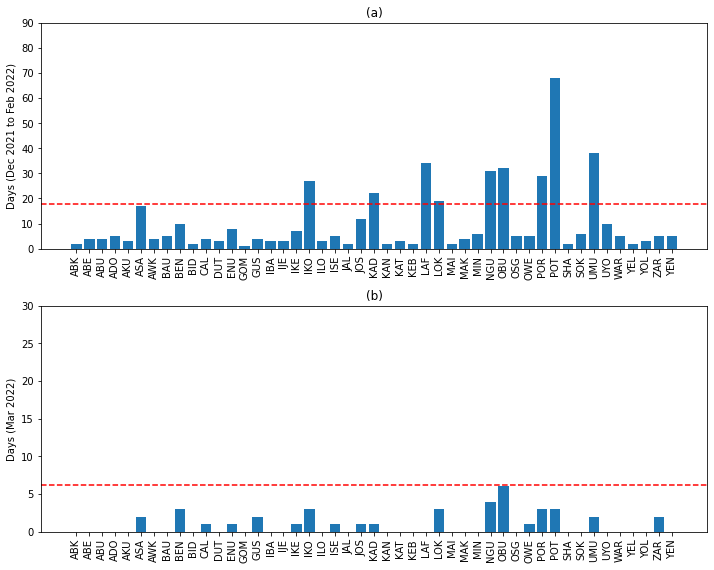

In [18]:
# plotting missing values for each station, the red line shows position of 20% missing values
bar_width=0.25
fig, (ax1, ax2) =plt.subplots(2, figsize=(10,8))

ax1.bar(name, missing_train)
ax1.set_title('(a)')
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_ylim([0,90])
ax1.axhline(y=(len_train/100)*20, color='r', linestyle='--')
ax1.set_ylabel('Days (Dec 2021 to Feb 2022)')

ax2.bar(name, missing_test)
ax2.set_title('(b)')
ax2.tick_params(axis='x', labelrotation=90)
ax2.set_ylim([0,30])
ax2.axhline(y=(len_test/100)*20, color='r', linestyle='--')
ax2.set_ylabel('Days (Mar 2022)')

fig.tight_layout(pad=1)

In [ ]:
bsc = xr.open_dataset("nc_files/ALADIN DUST/2021120100_3H_ALADIN_DUST.nc")
bsc

In [1]:
# all_models=['ALADIN_DUST', 
# all_variables=['od550_dust'
all_day1_lead=[('ALADIN_DUST', 'od550_dust', (11, 19)),
               ('BSC_DREAM8b_V2', 'OD550_DUST', (7, 15)),
               ('MACC-ECMWF', 'OD550_DUST', (11, 19)),
               ('DREAM8-MACC', 'OD550_DUST', (11, 19)),
               ('ICON-ART', 'OD550_DUST', (11, 19)),
               ('LOTOSEUROS', 'OD550_DUST', (11, 19)),
               ('MEDIAN', 'OD550_DUST', (7, 15)),
               ('NASA-GEOS', 'OD550_DUST', (11, 19)),
               ('NCEP-NGAC', 'OD550_DUST', (11, 19)),
               ('NMMB-BSC', 'od550_dust', (7, 15)),
               ('NOA-WRF-CHEM', 'OD550_DUST', (7, 15)),
               ('SILAM', 'OD550_DUST', (11, 19))]
               

In [6]:
for i, j, k in all_day1_lead:
    print(k[1])

19
15
19
19
19
19
15
19
19
15
15
19


In [ ]:
#11 19
bsc.time.to_series()[19]

In [ ]:
nc_files = os.listdir("nc_files/ALADIN DUST/")
len(nc_files)

In [ ]:
day1_lead_all = pd.DataFrame(columns=["stn", "lon", "lat"])
for nc_file in nc_files:
    bsc = xr.open_dataset("nc_files/ALADIN DUST/"+nc_file)
    day1_lead = [["stn", "lon", "lat", bsc.od550_dust.time.to_series()[19]]]
    for i in range(len(stn)):
        day1_bsc = bsc.od550_dust.isel(time = 19).sel(lat = stn_lat[i], 
                                                     lon = stn_lon[i], 
                                                     method = 'nearest')
        day1_lead.append([stn[i], stn_lon[i], stn_lat[i], day1_bsc.to_dict()["data"]])
    day1_lead = pd.DataFrame(day1_lead[1:len(day1_lead)], columns = day1_lead[0])
    day1_lead_all = day1_lead_all.merge(day1_lead, 
                                        left_on=["stn", "lon", "lat"], 
                                        right_on=["stn", "lon", "lat"],
                                        how = "outer")
#data for 1 day leadtime for all sations
day1_lead_all

In [ ]:
day1_lead_all_t = day1_lead_all.transpose()
day1_lead_all_t.columns = day1_lead_all_t.iloc[0]
day1_lead_all_t = day1_lead_all_t.drop(["lon", "lat", "stn"])

# multiply AOD by 10
# day1_lead_all_t = day1_lead_all_t * 10

day1_lead_all_t = day1_lead_all_t.reset_index()
day1_lead_all_t

In [ ]:
day1_lead_all_t["index"] = pd.to_datetime(day1_lead_all_t["index"], format="%Y-%m-%d").dt.date
day1_lead_all_t = day1_lead_all_t.set_index("index")
day1_lead_all_t

In [ ]:
# na.array(vis['YOL'])
# merged = pd.merge(vis[["YOL"]], day1_lead_all_t[["YOL"]], left_index=True, right_on="index")
merged = pd.concat([vis[["YOL"]], day1_lead_all_t[["YOL"]]], axis=1)
merged.columns = ["Visibility", "AOD"]
merged

In [ ]:
# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

cor_ls = []

fig = plt.figure(figsize=(12,16))
# fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, j in enumerate(stn):
    merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
    merged.columns = ["Visibility", "AOD"]
    a=merged.dropna()
#     regression part
    slope, intercept, r_value, p_value, std_err = stats.linregress(list(a['AOD']),list(a['Visibility']))
    line = (slope*a['AOD'])+intercept
    
    # append correlation
    cor_ls.append([stn_lat[i], stn_lon[i], j, round(r_value, 2), round(p_value, 2)])
    
    ax = fig.add_subplot(8,6,i+1, )
    ax.scatter(merged['AOD'], merged['Visibility'], color = 'k')
    ax.plot(list(a['AOD']), line, 'r')
    title = j+': y={:.2f}x+{:.2f} \n '.format(slope,intercept)  + 'r={:.2f}, '.format(r_value) + 'p-value={:.2f}'.format(p_value)

    ax.set_title(title, fontsize = 10)
#     ax.set_xlim([0, 1.5])
    ax.set_ylim([-1, 11])
    
#     ax.set_ylabel('Visibility (in Km)')
#     ax.set_xlabel('bbb')
# fig.suptitle('a')
fig.supxlabel('AOD')
fig.supylabel('Visibility (in Km)')
fig.tight_layout(rect=(0.0,0,1,1))
    
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X")
# plt.ylabel("common Y")    
#     plt.subplot(7,7,i+1)
#     plt.scatter(merged['AOD'], merged['Visibility'], color = 'k', ls='solid')
#     plt.title(j)
# plt.xlabel('AOD')
# plt.ylabel('Visibility (in Km)')
#     plt.text(j)
#     for j in stn:
        
#         plt.subplot(2, 3, i)
#         plt.scatter(merged['AOD'], merged['Visibility'])
# # #         plt.text(0.5, 0.5, str((2, 3, i)),
# # #                  fontsize=18, ha='center')
            


# # fig = plt.figure(figsize=(3,3))
# fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(15,15))
# plt.subplots_adjust(hspace=0.2)
# for j, ax in zip(stn, axs.ravel()):
#     print(j, ax)
#     merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
#     merged.columns = ["Visibility", "AOD"]
# #     merged['AOD'].scatter(merged['Visibility'],ax=ax)
#     plt.scatter(merged['AOD'], merged['Visibility'],ax=ax)
# #     plt.figure()
# #     plt.scatter(merged['AOD'], merged['Visibility'],color='k', ls='solid')
# #     plt.show()
    
    

In [ ]:
cor_df = pd.DataFrame(cor_ls, columns=["Lat", "Long", "Station", "r_value", "p_value"])
cor_df['p'] = 2
cor_df.loc[cor_df['p_value'] > 0.05, 'p'] = 1
cor_df

In [ ]:
# cor_df.to_csv("cor_files/day1/ALADIN_1d.csv", index=False)
cor_df.to_csv("cor_files/day2/ALADIN_2d.csv", index=False)
# cor_df.to_csv("cor_files/day3/ALADIN_3d.csv", index=False)

In [ ]:
# plot coastlines with Basemap
plt.figure(figsize=(8, 8))
m = Basemap(projection='cyl', resolution='h',
llcrnrlat=3, urcrnrlat=15,
llcrnrlon=2, urcrnrlon=15)
# m.drawmapboundary(fill_color='#DDEEFF')
# m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='grey', zorder=2)
m.drawcountries(color='black', zorder=2)
# m.shadedrelief()
m.drawstates()

# m.readshapefile('./nigeria_states/nigeria_states', 'nigeria_states')

# plot locations
m.scatter(cor_df["Long"], cor_df["Lat"], latlon=True, 
          c=cor_df["r_value"], s=cor_df["p"]*100,
          edgecolors="black", zorder=3,
          cmap='jet', alpha=0.7)

# create colorbar and legend
m.colorbar(label=r'r', ticks=np.linspace(1, -1, 9), shrink=0.755)
# plt.set_ticks(np.linspace(1, -1, 9))
plt.xticks(range(2, 16, 2))
plt.yticks(range(3, 16, 2))
plt.show()